In [1]:
import pandas as pd
import json

### data cleaning Opensky

### Construire les listes des altitudes et vitesses

In [5]:
import pandas as pd
import json
import math
import datetime as dt

In [6]:

def haversine_distance(lat1, long1, lat2, long2):
    R = 6371  # radius of Earth in kilometers
    lat1, long1, lat2, long2 = map(math.radians, [lat1, long1, lat2, long2])
    dlat = lat2 - lat1
    dlong = long2 - long1
    a = (math.sin(dlat/2)**2) + math.cos(lat1) * math.cos(lat2) * (math.sin(dlong/2)**2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = R * c
    return d

In [4]:
latitude_aero = 43.6293     #TOULOUSE
longitude_aero = 1.3676 
lat = 48.8567               #PARIS
long = 2.3508

distance = haversine_distance(latitude_aero, longitude_aero, lat, long)
print(distance)

586.14293769134


In [9]:

#data = pd.read_csv("output_example.csv")
#data = pd.read_csv("2022-09-29.csv")
data = pd.read_csv("2022-11-22.csv")
alt_list = []
lat_list = []
long_list = []
distance_aero_list = []
surf_list = []
rate_list = []
indice_list = []
flightid_list = []
sonore_list = []

latitude_aero = 43.6293
longitude_aero = 1.3676 

data['datetime'] = pd.to_datetime(data['timestamp_s'], unit='s')

for i in range (len(data)) :
   icao_addr = data.icao_adress_hex[i]
   jsn = data.data[i]
   jsn2 = json.loads(jsn)
   try:
      alt = jsn2["05_Altitude (ft)"]
      long = jsn2["05_Airborne Longitude (°)"]
      lat = jsn2["05_Airborne Latitude (°)"]
      vitesse_surf = jsn2["09_Surface Speed Calculated (knots)"]
      vitesse_rate = jsn2["09_sub1_Vertical Rate_Meaning"]
      flight_id = jsn2["08_Flight_ID"]
      air_sol = jsn2["AIR_SOL"]
      if (air_sol == 'SOL') : 
         indice_list.append(icao_addr)

      #calcul de la distance
      distance = haversine_distance(latitude_aero, longitude_aero, lat, long)
      
      #calcul du niveau sonore
      niveau = 57 + 20 * math.log10(vitesse_surf) - 15 * math.log10(alt) - 2 * math.log10(distance)

      if (vitesse_rate == "ZERO") : 
         rate_list.append(0)
      else :
         vitesse_split = vitesse_rate.split()
         if (vitesse_split[0] == "-") : 
            rate_list.append(-int(vitesse_split[1]))
         else : 
            rate_list.append(int(vitesse_split[1]))


      alt_list.append(alt)
      long_list.append(long)
      lat_list.append(lat)
      distance_aero_list.append(distance)
      surf_list.append(int(vitesse_surf))
      flightid_list.append(flight_id)
      sonore_list.append(niveau)
      
   except:
      #print("erreur")
      alt_list.append(-100)
      long_list.append(-100)
      lat_list.append(-100)
      surf_list.append(-100)
      rate_list.append(-100)
      distance_aero_list.append(-100)
      sonore_list.append(-100)
      flightid_list.append("")     # A verifier


data.loc[:, 'altitude'] = alt_list
data.loc[:, 'longitude'] = long_list
data.loc[:, 'latitude'] = lat_list
data.loc[:, 'distance_aero'] = distance_aero_list
data.loc[:, 'TAS'] = surf_list
data.loc[:, 'vertical_rate'] = rate_list
data.loc[:, 'Flight_ID'] = flightid_list
data.loc[:, 'niveau_sonore'] = sonore_list



data.drop(data[data['altitude']==-100].index,  inplace = True)
data = data.dropna(subset=['longitude','latitude'])

data

,icao_adress_hex,timestamp_s,data,datetime,altitude,longitude,latitude,distance_aero,TAS,vertical_rate,Flight_ID,niveau_sonore
0,3950ce,1669007662,"{""05_Airborne Latitude (°)"":43.57559462725106,...",2022-11-21 05:14:22,8725,1.331111,43.575595,6.655404,230,2112,AFR36JR,43.484355
1,3950ce,1669007661,"{""05_Airborne Latitude (°)"":43.57559462725106,...",2022-11-21 05:14:21,8725,1.331111,43.575595,6.655404,246,1600,AFR36JR,44.068759
2,3950ce,1669007660,"{""05_Airborne Latitude (°)"":43.57559462725106,...",2022-11-21 05:14:20,8725,1.331111,43.575595,6.655404,242,1664,AFR36JR,43.937789
3,3950ce,1669007659,"{""05_Airborne Latitude (°)"":43.57559462725106,...",2022-11-21 05:14:19,8725,1.331111,43.575595,6.655404,241,1728,AFR36JR,43.895129
4,3c6637,1669007659,"{""05_Airborne Latitude (°)"":43.54789604574947,...",2022-11-21 05:14:19,5000,1.455100,43.547896,11.471547,248,2368,DLH95E,47.308128
...,...,...,...,...,...,...,...,...,...,...,...,...
35224,a48c07,1668998245,"{""05_Airborne Latitude (°)"":46.51615983348782,...",2022-11-21 02:37:25,35025,2.900047,46.516160,342.800560,494,64,UPS242,37.639229
35226,a48c07,1668998244,"{""05_Airborne Latitude (°)"":46.51853942871094,...",2022-11-21 02:37:24,35025,2.900056,46.518539,343.047669,494,0,UPS242,37.638603
35227,a48c07,1668998243,"{""05_Airborne Latitude (°)"":46.52082824707031,...",2022-11-21 02:37:23,35025,2.900123,46.520828,343.286997,494,-64,UPS242,37.637837
35228,a48c07,1668998242,"{""05_Airborne Latitude (°)"":46.52346853482521,...",2022-11-21 02:37:22,35000,2.900185,46.523469,343.562682,494,-64,UPS242,37.641791


In [10]:
indice_list = [*set(indice_list)]
print(len(indice_list))
indice_list

2


['3950ce', '45ce56']

In [11]:
#icao_liste = data.iloc[indice_list].icao_adress_hex.drop_duplicates()
#indice_list.drop_duplicates()
data = data[ data['icao_adress_hex'].isin(indice_list) ]
data

,icao_adress_hex,timestamp_s,data,datetime,altitude,longitude,latitude,distance_aero,TAS,vertical_rate,Flight_ID,niveau_sonore
0,3950ce,1669007662,"{""05_Airborne Latitude (°)"":43.57559462725106,...",2022-11-21 05:14:22,8725,1.331111,43.575595,6.655404,230,2112,AFR36JR,43.484355
1,3950ce,1669007661,"{""05_Airborne Latitude (°)"":43.57559462725106,...",2022-11-21 05:14:21,8725,1.331111,43.575595,6.655404,246,1600,AFR36JR,44.068759
2,3950ce,1669007660,"{""05_Airborne Latitude (°)"":43.57559462725106,...",2022-11-21 05:14:20,8725,1.331111,43.575595,6.655404,242,1664,AFR36JR,43.937789
3,3950ce,1669007659,"{""05_Airborne Latitude (°)"":43.57559462725106,...",2022-11-21 05:14:19,8725,1.331111,43.575595,6.655404,241,1728,AFR36JR,43.895129
5,3950ce,1669007658,"{""05_Airborne Latitude (°)"":43.57559462725106,...",2022-11-21 05:14:18,8725,1.331111,43.575595,6.655404,241,1792,AFR36JR,43.895129
...,...,...,...,...,...,...,...,...,...,...,...,...
9686,45ce56,1669004808,"{""05_Airborne Latitude (°)"":45.31178283691406,...",2022-11-21 04:26:48,29000,4.013214,45.311783,281.166068,385,0,SRR6374,36.889126
9690,45ce56,1669004807,"{""05_Airborne Latitude (°)"":45.31260681152344,...",2022-11-21 04:26:47,29000,4.014849,45.312607,281.322718,385,0,SRR6374,36.888642
9694,45ce56,1669004806,"{""05_Airborne Latitude (°)"":45.314832784361755...",2022-11-21 04:26:46,29000,4.019455,45.314833,281.757146,385,0,SRR6374,36.887302
9697,45ce56,1669004805,"{""05_Airborne Latitude (°)"":45.314832784361755...",2022-11-21 04:26:45,29000,4.019455,45.314833,281.757146,385,-64,SRR6374,36.887302


In [12]:
data_filter = data.filter( items = ["icao_adress_hex", "Flight_ID", "timestamp_s", "datetime", "altitude", "longitude", "latitude", "distance_aero", "TAS", "vertical_rate", "niveau_sonore"])
data_group = data_filter.groupby(['icao_adress_hex', 'Flight_ID']).agg(lambda x: x.tolist())
len(data_group)
data_group

,,timestamp_s,datetime,altitude,longitude,latitude,distance_aero,TAS,vertical_rate,niveau_sonore
icao_adress_hex,Flight_ID,,,,,,,,,
3950ce,AFR36JR,"[1669007662, 1669007661, 1669007660, 166900765...","[2022-11-21 05:14:22, 2022-11-21 05:14:21, 202...","[8725, 8725, 8725, 8725, 8725, 8725, 8725, 872...","[1.3311113630022322, 1.3311113630022322, 1.331...","[43.57559462725106, 43.57559462725106, 43.5755...","[6.655404340801834, 6.655404340801834, 6.65540...","[230, 246, 242, 241, 241, 239, 237, 236, 233, ...","[2112, 1600, 1664, 1728, 1792, 1856, 1920, 198...","[43.48435463590659, 44.06875872598217, 43.9377..."
45ce56,SRR6374,"[1669007114, 1669007113, 1669007112, 166900711...","[2022-11-21 05:05:14, 2022-11-21 05:05:13, 202...","[525, 525, 525, 525, 525, 525, 525, 525, 525, ...","[1.3770595816678781, 1.3770595816678781, 1.377...","[43.623779296875, 43.623779296875, 43.62377929...","[0.9780365527625454, 0.9780365527625454, 0.978...","[2, 2, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[24.175700449859175, 24.175700449859175, 25.75..."


In [13]:
data_group['niveau_sonore'][0]

[43.48435463590659,
 44.06875872598217,
 43.937788932747175,
 43.89512887124713,
 43.89512887124713,
 43.82856384559194,
 43.766188462748836,
 43.73466157348545,
 43.60469999301669,
 43.55725141022683,
 43.63264756590894,
 43.63264756590894,
 43.59015249799707,
 43.54088071496935,
 43.516286143561786,
 43.5948997362018,
 43.54066232177717,
 43.596338076801025,
 43.60100113215184,
 43.60100113215184,
 43.6616181364512,
 43.69146191569076,
 43.82966738521514,
 43.85417033830878,
 43.96556123528853,
 44.01954098369745,
 44.15408160895923,
 44.178481417178816,
 44.20291119759351,
 44.37211529736943,
 44.59329328882715,
 44.64584538083985,
 44.64584538083985,
 44.84228025779202,
 45.017944288099045,
 45.017944288099045,
 45.04159049584011,
 45.22001880651596,
 45.22001880651596,
 45.350817807493975,
 45.460375375687136,
 45.460375375687136,
 45.56797197504512,
 45.540448659215194,
 45.62832693471367,
 45.62832693471367,
 45.742740546327475,
 45.774343376438416,
 45.86453276253668,
 45.86453

In [14]:
#calcul de l'indice de performance sonore

def sum_sonore(x):
    return 10**(x/10)

list_indice = []
for i in range (len(data_group)) :
   
    list_niv = list(map(sum_sonore, data_group['niveau_sonore'][i]))
    indice_perfo = 10*math.log10(sum(list_niv))
    list_indice.append(indice_perfo)


data_group.loc[:, 'indice_sonore'] = list_indice

data_group = data_group.drop(columns=['niveau_sonore'])

data_group

,,timestamp_s,datetime,altitude,longitude,latitude,distance_aero,TAS,vertical_rate,indice_sonore
icao_adress_hex,Flight_ID,,,,,,,,,
3950ce,AFR36JR,"[1669007662, 1669007661, 1669007660, 166900765...","[2022-11-21 05:14:22, 2022-11-21 05:14:21, 202...","[8725, 8725, 8725, 8725, 8725, 8725, 8725, 872...","[1.3311113630022322, 1.3311113630022322, 1.331...","[43.57559462725106, 43.57559462725106, 43.5755...","[6.655404340801834, 6.655404340801834, 6.65540...","[230, 246, 242, 241, 241, 239, 237, 236, 233, ...","[2112, 1600, 1664, 1728, 1792, 1856, 1920, 198...",75.666465
45ce56,SRR6374,"[1669007114, 1669007113, 1669007112, 166900711...","[2022-11-21 05:05:14, 2022-11-21 05:05:13, 202...","[525, 525, 525, 525, 525, 525, 525, 525, 525, ...","[1.3770595816678781, 1.3770595816678781, 1.377...","[43.623779296875, 43.623779296875, 43.62377929...","[0.9780365527625454, 0.9780365527625454, 0.978...","[2, 2, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",76.882388


In [15]:
#data_group.to_csv('data_group.csv')
data_group.to_csv('data_group_exemple.csv')

### jointure

In [16]:
import pandas as pd

#csv_ADSB = "data_group.csv"
csv_ADSB = "data_group_exemple.csv"
data = pd.read_csv(csv_ADSB)

data2 = pd.read_csv("new_opensky_09_2022.csv")
data_new = data2.set_index('icao_address').join(data.set_index('icao_adress_hex'))

data_new_na = data_new.dropna(subset=['timestamp_s','altitude', 'TAS', 'vertical_rate'])

data_new_na = data_new_na.loc[:, ~data_new_na.columns.str.contains('^Unnamed')]

#data_new_na.to_csv('data_join.csv')
data_new_na.to_csv('data_join_exemple.csv')

print(len(data_new_na))
data_new_na



2


,tale_nb,type_avion,jet_prive,serial_nb,Flight_ID,timestamp_s,datetime,altitude,longitude,latitude,distance_aero,TAS,vertical_rate,indice_sonore
icao_address,,,,,,,,,,,,,,
3950ce,F-GUGO,A318,Air France,2951,AFR36JR,"[1669007662, 1669007661, 1669007660, 166900765...","[Timestamp('2022-11-21 05:14:22'), Timestamp('...","[8725, 8725, 8725, 8725, 8725, 8725, 8725, 872...","[1.3311113630022322, 1.3311113630022322, 1.331...","[43.57559462725106, 43.57559462725106, 43.5755...","[6.655404340801834, 6.655404340801834, 6.65540...","[230, 246, 242, 241, 241, 239, 237, 236, 233, ...","[2112, 1600, 1664, 1728, 1792, 1856, 1920, 198...",75.666465
45ce56,OY-SRV,B763,Star Air,35816,SRR6374,"[1669007114, 1669007113, 1669007112, 166900711...","[Timestamp('2022-11-21 05:05:14'), Timestamp('...","[525, 525, 525, 525, 525, 525, 525, 525, 525, ...","[1.3770595816678781, 1.3770595816678781, 1.377...","[43.623779296875, 43.623779296875, 43.62377929...","[0.9780365527625454, 0.9780365527625454, 0.978...","[2, 2, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",76.882388


In [ ]:
def sum_sonore(x):
    return 10**(x/10)


def clean_data(data):

    alt_list = []
    lat_list = []
    long_list = []
    distance_aero_list = []
    surf_list = []
    rate_list = []
    indice_list = []
    flightid_list = []
    sonore_list = []

    latitude_aero = 43.6293
    longitude_aero = 1.3676 

    data['datetime'] = pd.to_datetime(data['timestamp_s'], unit='s')

    for i in range (len(data)) :
        icao_addr = data.icao_adress_hex[i]
        jsn = data.data[i]
        jsn2 = json.loads(jsn)
        try:
            alt = jsn2["05_Altitude (ft)"]
            long = jsn2["05_Airborne Longitude (°)"]
            lat = jsn2["05_Airborne Latitude (°)"]
            vitesse_surf = jsn2["09_Surface Speed Calculated (knots)"]
            vitesse_rate = jsn2["09_sub1_Vertical Rate_Meaning"]
            flight_id = jsn2["08_Flight_ID"]
            air_sol = jsn2["AIR_SOL"]
            if (air_sol == 'SOL') : 
                indice_list.append(icao_addr)

            #calcul de la distance
            distance = haversine_distance(latitude_aero, longitude_aero, lat, long)
            
            #calcul du niveau sonore
            niveau = 57 + 20 * math.log10(vitesse_surf) - 15 * math.log10(alt) - 2 * math.log10(distance)

            if (vitesse_rate == "ZERO") : 
                rate_list.append(0)
            else :
                vitesse_split = vitesse_rate.split()
                if (vitesse_split[0] == "-") : 
                    rate_list.append(-int(vitesse_split[1]))
                else : 
                    rate_list.append(int(vitesse_split[1]))


            alt_list.append(alt)
            long_list.append(long)
            lat_list.append(lat)
            distance_aero_list.append(distance)
            surf_list.append(int(vitesse_surf))
            flightid_list.append(flight_id)
            sonore_list.append(niveau)
            
        except:
            #print("erreur")
            alt_list.append(-100)
            long_list.append(-100)
            lat_list.append(-100)
            surf_list.append(-100)
            rate_list.append(-100)
            distance_aero_list.append(-100)
            sonore_list.append(-100)
            flightid_list.append("")     # A verifier


    data.loc[:, 'altitude'] = alt_list
    data.loc[:, 'longitude'] = long_list
    data.loc[:, 'latitude'] = lat_list
    data.loc[:, 'distance_aero'] = distance_aero_list
    data.loc[:, 'TAS'] = surf_list
    data.loc[:, 'vertical_rate'] = rate_list
    data.loc[:, 'Flight_ID'] = flightid_list
    data.loc[:, 'niveau_sonore'] = sonore_list



    data.drop(data[data['altitude']==-100].index,  inplace = True)
    data = data.dropna(subset=['longitude','latitude'])

    indice_list = [*set(indice_list)]
    data = data[ data['icao_adress_hex'].isin(indice_list) ]

    data_filter = data.filter( items = ["icao_adress_hex", "Flight_ID", "timestamp_s", "datetime", "altitude", "longitude", "latitude", "distance_aero", "TAS", "vertical_rate", "niveau_sonore"])
    data_group = data_filter.groupby(['icao_adress_hex', 'Flight_ID']).agg(lambda x: x.tolist())

    #calcul de l'indice de performance sonore
    list_indice = []
    for i in range (len(data_group)) :
    
        list_niv = list(map(sum_sonore, data_group['niveau_sonore'][i]))
        indice_perfo = 10*math.log10(sum(list_niv))
        list_indice.append(indice_perfo)

    data_group.loc[:, 'indice_sonore'] = list_indice
    data_group = data_group.drop(columns=['niveau_sonore'])

    return data_group

In [ ]:
def jointure_data(data_join, data_group):

    data_new = data_join.set_index('icao_address').join(data_group.set_index('icao_adress_hex'))

    data_new_na = data_new.dropna(subset=['timestamp_s','altitude', 'TAS', 'vertical_rate'])

    data_new_na = data_new_na.loc[:, ~data_new_na.columns.str.contains('^Unnamed')]

    data_new_na.to_csv('data_join.csv')
    #data_new_na.to_csv('data_join_exemple.csv')

### OpenAP 

In [24]:
tas = data_new_na.TAS
tas

icao_address
02a1ae    [448, 448, 448, 448, 448, 448, 448, 448, 448, ...
342591    [376, 376, 376, 376, 376, 377, 377, 377, 377, ...
345398    [457, 457, 457, 457, 457, 457, 457, 457, 457, ...
34569a    [444, 444, 444, 444, 443, 443, 443, 444, 444, ...
34608c    [449, 449, 449, 448, 449, 448, 448, 448, 448, ...
346350    [420, 420, 420, 420, 420, 419, 419, 419, 419, ...
34648e    [448, 448, 448, 448, 448, 447, 447, 447, 447, ...
399251    [424, 424, 423, 423, 423, 423, 423, 423, 423, ...
400e5a    [441, 441, 441, 441, 441, 441, 441, 441, 441, ...
406011    [445, 445, 445, 445, 445, 445, 445, 445, 446, ...
406668    [12, 12, 12, 12, 12, 12, 15, 15, 15, 15, 14, 1...
4075df    [434, 434, 434, 434, 434, 434, 434, 434, 434, ...
44cdcd    [452, 452, 452, 452, 452, 452, 452, 452, 452, ...
471f8a    [495, 495, 495, 495, 495, 495, 495, 495, 495, ...
484f06    [462, 462, 462, 462, 462, 461, 461, 461, 461, ...
4bb18b    [547, 547, 547, 547, 547, 547, 547, 547, 547, ...
4ca646    [321, 321, 321, 3

In [3]:
from openap import prop
import ast

aircraft = prop.aircraft('b734')
data_new_na = pd.read_csv("data_join.csv")

In [4]:
list_type = data_new_na.type_avion
ac = list_type
len(ac)

47

[[0.54558095 0.54558095 0.54597407 ... 0.55233118 0.55233118 0.57613088]
 [0.54558095 0.54558095 0.54597407 ... 0.55233118 0.55233118 0.57613088]
 [0.54558095 0.54558095 0.54597407 ... 0.55233118 0.55233118 0.57613088]
 ...
 [0.54357332 0.54357332 0.54401436 ... 0.55102844 0.55102844 0.57647458]
 [0.54351231 0.54351231 0.54395488 ... 0.55098992 0.55098992 0.57648869]
 [0.53673762 0.53673762 0.53739753 ... 0.54742388 0.54742388 0.58052103]]


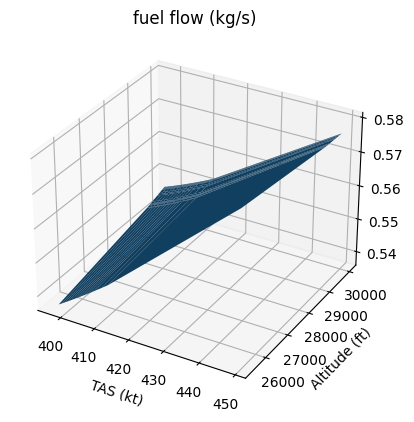

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from openap import Emission, FuelFlow, prop
from mpl_toolkits.mplot3d import Axes3D



list_type = data_new_na.type_avion
list_tas = data_new_na.TAS
list_alt = data_new_na.altitude

ac = list_type[5]

aircraft = prop.aircraft(ac)
fuelflow = FuelFlow(ac=ac)
emission = Emission(ac=ac)



tas = ast.literal_eval(list_tas[5])
alt = ast.literal_eval(list_alt[5])
tas_, alt_ = np.meshgrid(tas, alt)
mass = aircraft["limits"]["MTOW"] * 0.85

ff = fuelflow.enroute(mass=mass, tas=tas_, alt=alt_, path_angle=0)

print(ff)

co2 = emission.co2(ff)
h2o = emission.h2o(ff)
sox = emission.sox(ff)
nox = emission.nox(ff, tas=tas_, alt=alt_)
co = emission.co(ff, tas=tas_, alt=alt_)
hc = emission.hc(ff, tas=tas_, alt=alt_)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
surf = ax.plot_surface(tas_, alt_, ff)
plt.title("fuel flow (kg/s)")
plt.xlabel("TAS (kt)")
plt.ylabel("Altitude (ft)")
plt.show()


In [52]:
import numpy as np
import matplotlib.pyplot as plt
from openap import Emission, FuelFlow, prop
from mpl_toolkits.mplot3d import Axes3D

def indicateurs_env(ac, tas, alt) : 
        
    aircraft = prop.aircraft(ac)
    fuelflow = FuelFlow(ac=ac)
    emission = Emission(ac=ac)

    tas_, alt_ = np.meshgrid(tas, alt)
    mass = aircraft["limits"]["MTOW"] * 0.85


    ff = fuelflow.enroute(mass=mass, tas=tas_, alt=alt_, path_angle=0)

    co2 = emission.co2(ff)
    h2o = emission.h2o(ff)
    sox = emission.sox(ff)
    nox = emission.nox(ff, tas=tas_, alt=alt_)
    co = emission.co(ff, tas=tas_, alt=alt_)
    hc = emission.hc(ff, tas=tas_, alt=alt_)

    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    surf = ax.plot_surface(tas_, alt_, ff)
    plt.title("fuel flow (kg/s)")
    plt.xlabel("TAS (kt)")
    plt.ylabel("Altitude (ft)")
    plt.show()

    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    surf = ax.plot_surface(tas_, alt_, h2o)
    plt.title("H2O (g/s)")
    plt.xlabel("TAS (kt)")
    plt.ylabel("Altitude (ft)")
    plt.show()

    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    surf = ax.plot_surface(tas_, alt_, co2)
    plt.title("CO2 (kg/s)")
    plt.xlabel("TAS (kt)")
    plt.ylabel("Altitude (ft)")
    plt.show()

    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    surf = ax.plot_surface(tas_, alt_, sox)
    plt.title("SOx (g/s)")
    plt.xlabel("TAS (kt)")
    plt.ylabel("Altitude (ft)")
    plt.show()

    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    surf = ax.plot_surface(tas_, alt_, nox)
    plt.title("NOx (g/s)")
    plt.xlabel("TAS (kt)")
    plt.ylabel("Altitude (ft)")
    plt.show()

    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    surf = ax.plot_surface(tas_, alt_, co)
    plt.title("CO (g/s)")
    plt.xlabel("TAS (kt)")
    plt.ylabel("Altitude (ft)")
    plt.show()

    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    surf = ax.plot_surface(tas_, alt_, hc)
    plt.title("HC (g/s)")
    plt.xlabel("TAS (kt)")
    plt.ylabel("Altitude (ft)")
    plt.show()

In [ ]:
def indicateurs_env_ligne(data, nb):

    list_type = data.type_avion
    list_tas = data.TAS
    list_alt = data.altitude

    ac = list_type[nb]
    tas = ast.literal_eval(list_tas[nb])
    alt = ast.literal_eval(list_alt[nb])

    indicateurs_env(ac, tas, alt)

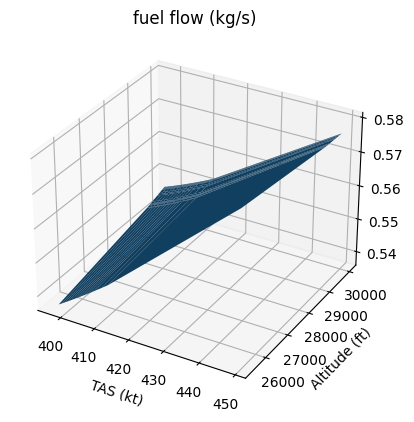

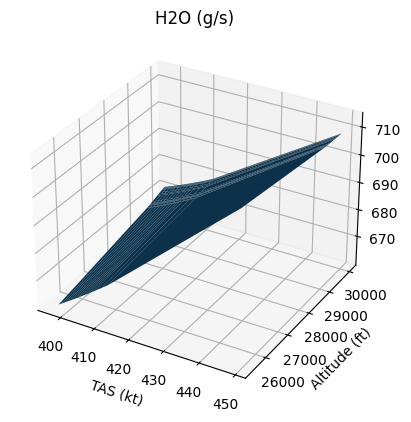

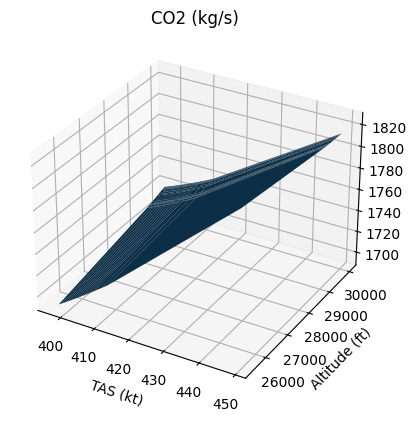

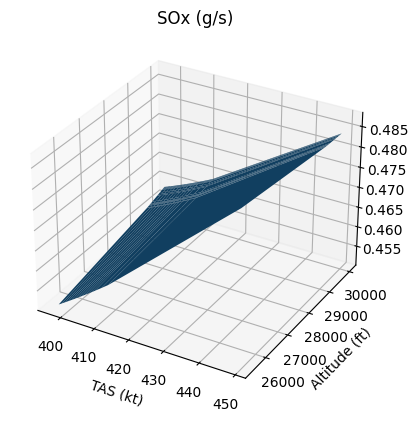

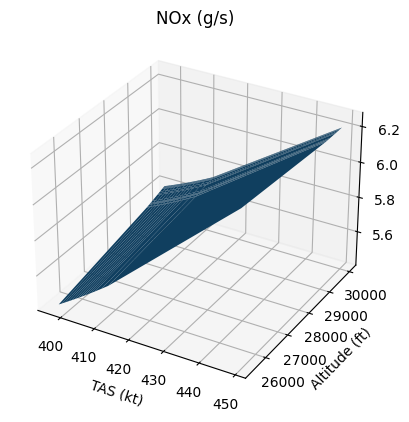

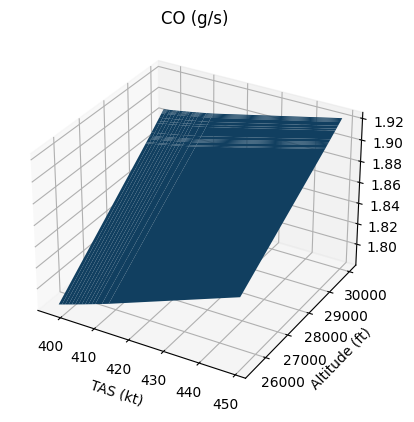

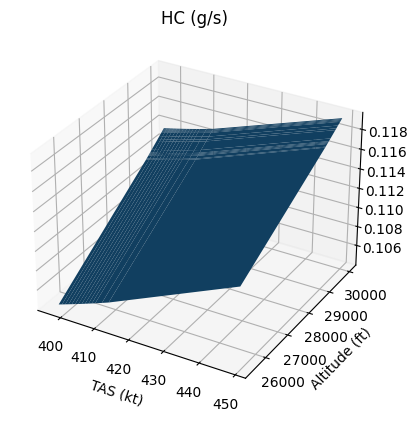

In [53]:
list_type = data_new_na.type_avion
list_tas = data_new_na.TAS
list_alt = data_new_na.altitude

ac = list_type[5]

aircraft = prop.aircraft(ac)
fuelflow = FuelFlow(ac=ac)
emission = Emission(ac=ac)


tas = ast.literal_eval(list_tas[5])
alt = ast.literal_eval(list_alt[5])

indicateurs_env(ac, tas, alt)

### Base de données pour classifier les indicateurs env

In [36]:
from openap import prop
import ast
import numpy as np
import matplotlib.pyplot as plt
from openap import Emission, FuelFlow, prop
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import json
import math

data_new_na = pd.read_csv("data_join.csv")

In [37]:

def indicateurs(ac, tas, alt) : 
        
    aircraft = prop.aircraft(ac)
    fuelflow = FuelFlow(ac=ac)
    emission = Emission(ac=ac)

    tas_, alt_ = np.meshgrid(tas, alt)
    mass = aircraft["limits"]["MTOW"] * 0.85


    ff = fuelflow.enroute(mass=mass, tas=tas_, alt=alt_, path_angle=0)
    ff = np.array(ff)

    co2 = emission.co2(ff)
    h2o = emission.h2o(ff)
    sox = emission.sox(ff)
    nox = emission.nox(ff, tas=tas_, alt=alt_)
    co = emission.co(ff, tas=tas_, alt=alt_)
    hc = emission.hc(ff, tas=tas_, alt=alt_)

    return np.mean(ff), np.mean(co2), np.mean(h2o), np.mean(sox), np.mean(nox), np.mean(co), np.mean(hc)
    #return np.mean(ff), np.mean(co2)

In [38]:
list_type = data_new_na.type_avion
list_tas = data_new_na.TAS
list_alt = data_new_na.altitude

#créer une dataframe :
df_conso = pd.DataFrame(columns=['type_avion', 'consommation_carburant'])
#df_emission = pd.DataFrame(columns=['type_avion', 'emission_co2'])
df_emission = pd.DataFrame(columns=['type_avion', 'emission_co2', 'emission_h2o', 'emission_sox', 'emission_nox', 'emission_co', 'emission_hc'])


In [39]:
ac = list_type[5]

aircraft = prop.aircraft(ac)
fuelflow = FuelFlow(ac=ac)
emission = Emission(ac=ac)


tas = ast.literal_eval(list_tas[5])
alt = ast.literal_eval(list_alt[5])

ff, co2, h2o, sox, nox, co, hc = indicateurs(ac, tas, alt)
print(ff)
print(co2)
print(h2o)

0.5482482456046812
1726.4337254091413
674.345342093758


In [40]:
df_conso = pd.DataFrame(columns=['type_avion', 'consommation_carburant'])
df_conso.loc[0] = ['a0000',ff]
df_conso['consommation_carburant']
df_conso.to_csv('aircraft_consommations_data.csv')

In [41]:

for i in range (len(list_type)) : 
    print(i)
    try : 

        ac = list_type[i]

        aircraft = prop.aircraft(ac)
        fuelflow = FuelFlow(ac=ac)
        emission = Emission(ac=ac)

        tas = ast.literal_eval(list_tas[i])
        alt = ast.literal_eval(list_alt[i])

        ff, co2, h2o, sox, nox, co, hc = indicateurs(ac, tas, alt)
        #ff, co2 = indicateurs(ac, tas, alt)

        df_conso.loc[i] = [ac, ff]
        #df_emission.loc[i] = [ac, co2]
        df_emission.loc[i] = [ac, co2, h2o, sox, nox, co, hc]
        #df2 = pd.DataFrame([[ac, ff]],columns=["type_avion","consommation_carburant"])  
        # for appending df2 at the end of df1
        #df_conso = df_conso.append(df2, ignore_index = True)

    except:

        print('erreur')

df_conso

0
1
erreur
2
erreur
3
erreur
4
5
6
erreur
7
8
9
10
11
erreur
12
erreur
13
erreur
14
15
erreur
16
erreur
17
erreur
18
erreur
19
erreur
20
erreur
21
22
23
24
25
26
erreur
27
erreur
28
erreur
29
30
erreur
31
32
erreur
33
34
35
36
37
38
39
40
41
42
erreur
43
44
45
46


,type_avion,consommation_carburant
0,B738,0.664793
4,A319,1.432399
5,A320,0.548248
7,A321,0.745348
8,A321,0.848365
9,A321,0.953959
10,A319,0.863860
14,A321,0.927312
21,A320,1.362069
22,A320,0.871146


In [42]:
df_emission

,type_avion,emission_co2,emission_h2o,emission_sox,emission_nox,emission_co,emission_hc
0,B738,2093.434017,817.695726,0.558426,8.020637,1.570267,0.122098
4,A319,4510.624666,1761.850854,1.203215,27.323452,2.945058,0.155610
5,A320,1726.433725,674.345342,0.460529,5.647612,1.881857,0.113343
7,A321,2347.101740,916.778387,0.626093,9.816522,1.837604,0.171764
8,A321,2671.502760,1043.489487,0.712627,15.113738,1.897524,0.193689
9,A321,3004.017174,1173.369681,0.801326,19.062692,2.263478,0.248574
10,A319,2720.294433,1062.547524,0.725642,12.446146,3.029989,0.120858
14,A321,2920.104774,1140.593481,0.778942,17.722233,2.225482,0.241990
21,A320,4289.154117,1675.344415,1.144138,28.270824,1.334052,0.215972
22,A320,2743.239449,1071.509852,0.731763,15.416551,2.435403,0.245449


In [ ]:
def construct_conso_emission(data):

    list_type = data.type_avion
    list_tas = data.TAS
    list_alt = data.altitude
    
    #créer une dataframe :
    df_conso = pd.DataFrame(columns=['type_avion', 'consommation_carburant'])
    df_emission = pd.DataFrame(columns=['type_avion', 'emission_co2', 'emission_h2o', 'emission_sox', 'emission_nox', 'emission_co', 'emission_hc'])

    for i in range (len(list_type)) : 
        try : 

            ac = list_type[i]
            tas = ast.literal_eval(list_tas[i])
            alt = ast.literal_eval(list_alt[i])

            ff, co2, h2o, sox, nox, co, hc = indicateurs(ac, tas, alt)

            df_conso.loc[i] = [ac, ff]
            df_emission.loc[i] = [ac, co2, h2o, sox, nox, co, hc]

        except:
            print('erreur')

    return df_conso, df_emission

In [43]:
df_conso.to_csv('aircraft_consommations_data.csv')
df_emission.to_csv('aircraft_emissions_data.csv')